This paper uses the BG-level dataset as a starting point, imputes missing values, and compiles a CT-level dataset.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
pd.options.mode.chained_assignment = None  # default='warn'
import us
import state_name_crs_mappings_ML as crsm
from shapely.ops import unary_union
import segregation
import inequality
from pysal.explore import esda
from pysal.lib import weights
from inequality.gini import Gini
from inequality.gini import Gini_Spatial
from pysal.explore import esda  # Exploratory Spatial analytics
from pysal.lib import weights  # Spatial weights
import geopandas as geopd

In [ ]:
# All states
states = []
for state in us.states.STATES:
    states +=[state.name]
states += ['District of Columbia']
print(states)

# Data definition

Units (https://www.census.gov/programs-surveys/geography/guidance/geo-identifiers.html + data.gov):
- 15-digit FIPS code (?): A census block is the smallest geographic unit used by the United States Census Bureau for tabulation of 100-percent data (data collected from all houses, rather than a sample of houses). The number of blocks in the United States, including Puerto Rico, for the 2010 Census was 11,155,486.[1] Census blocks are grouped into block groups, which are grouped into census tracts. There are on average about 39 blocks per block group.
- 12-digit FIPS code: A Census Block Group is a geographical unit used by the United States Census Bureau which is between the Census Tract and the Census Block. It is the smallest geographical unit for which the bureau publishes sample data, i.e. data which is only collected from a fraction of all households. Typically, Block Groups have a population of 600 to 3,000 people.
- 11-digit FIPS code: Census tracts generally have a population size between 1,200 and 8,000 people, with an optimum size of 4,000 people. 

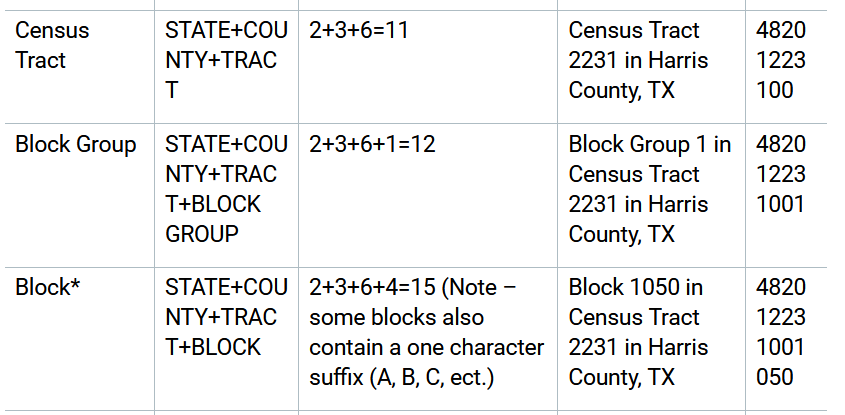

# Read BG-level data

In [ ]:
label = '240703'
label = '250429'
label_NEW = '250702'

path = 'C:/Users/bt309445/Documents/Data/'
result_path_OLD = 'C:/Users/bt309445/Documents/Research/EV_USMarketStructure/charging-location-POIs/'
result_path = 'c:/Users/bt309445/Documents/Research/EV_USMarketStructure/charging-location-POIs/final_data/'
path_geodata = 'C:/Users/bt309445/Documents/Data/geodata/'

In [ ]:
# Check whether folder exists, if not create it
import os
if not os.path.exists(result_path + 'CTlevel/'):
    os.makedirs(result_path + 'CTlevel/')

In [ ]:
# Read BG-level compiled data with cluster labels
df_dataset_BG = pd.read_csv(result_path + 'BGlevel/21c_level_BG_US_compiled_wlabels_250702.csv')

In [ ]:
# Bring to right format
df_dataset_BG.BGFP = df_dataset_BG.BGFP.astype(str).str.zfill(12)
df_dataset_BG.COUNTYFP = df_dataset_BG.COUNTYFP.astype(str).str.zfill(5)
df_dataset_BG.STATEFP = df_dataset_BG.STATEFP.astype(int).astype(str).str.zfill(2)
df_dataset_BG[['BGFP','COUNTYFP','STATEFP','median_age_byBG']].head()

# Define columns to be imputed

In [ ]:
# Columns which are kept as is (given that all BGs are in same county)
keep_columns = ['COUNTYFP', 'STATEFP','median_household_income_byCNTY','COUNTYNAME']
# Columns for which data needs to be added across groups within a tract
sum_columns = ['BGALAND', 'total_pop_byBG', 'total_modes_byBG',
       'total_housingunits_byBG',  'total_ResCars_byBG','no_stations_all', 'no_stations',
       'no_stations_privateonly', 'no_stations_publiconly', 'no_L2_stations', 'no_DC_stations',
       'no_stations_ChargePoint_Network',
       'no_stations_EV_Connect',
       'no_stations_Non-Networked',
       'no_stations_SemaCharge_Network', 'no_stations_Tesla',
       'no_stations_Tesla_Destination', 'no_PoI', 'no_PoI_Commercial',
       'no_PoI_Education/Child_Care', 'no_PoI_Gas_Station', 'no_PoI_Hotels',
       'no_PoI_Manufacturing', 'no_PoI_Medical', 'no_PoI_Office',
       'no_PoI_Recreation', 
       'no_PoI_Restaurants_and_Bars', 'no_PoI_Transit',
       # From 21c
       'no_stations_k8_University_college_campuses',
       'no_stations_k8_Weekday_daytime_short_stops',
       'no_stations_k8_City_neighborhoods',
       'no_stations_k8_Weekday_daytime_long_stops',
       'no_stations_k8_Gas_stations_very_short_stops',
       'no_stations_k8_Weekend_evening_recreation',
       'no_stations_k8_High_density_city',
       'no_stations_k8_Hotels'
       ]
# Columns for which data needs to be weighted by population
weigh_columns = ['median_age_byBG', 'median_household_income_byBG', 'median_family_income_byBG', 'per_capita_income_byBG','median_number_rooms_byBG',
       'share_mixedrace_byBG', 'share_white_byBG', 'share_black_byBG', 'share_native_byBG',
       'share_asian_byBG', 'share_workoutofhome_byBG', 'share_mode_public_byBG',
       'share_mode_taxi_byBG', 'share_mode_motorcycle_byBG','share_mode_bike_byBG', 'share_mode_walk_byBG', 'share_mode_car_byBG',
       'share_mode_other_byBG', 'share_workfromhome_byBG', 'share_mode_caralone_byBG',
       'avg_commutetime_byBG', 'share_commute40_byBG', 'share_commute45_byBG',
       'share_commute60_byBG', 'share_commute90_byBG', 'share_commute0_byBG',
       'share_commute5_byBG', 'share_commute10_byBG', 'share_commute15_byBG',
       'share_commute20_byBG', 'share_commute25_byBG', 'share_commute30_byBG',
       'share_commute35_byBG', 'share_children_byBG','share_education_byBG', 'share_highschool_byBG', 'share_noschooling_byBG',
       'share_college_byBG', 'share_associate_byBG', 'share_bachelor_byBG', 'share_master_byBG',
       'share_professional_byBG', 'share_PhD_byBG', 'share_bachelorbyfield_byBG',
       'share_business_byBG', 'share_CS_byBG', 'share_environ_byBG', 'share_physical_byBG',
       'share_engineering_byBG', 'share_engineeringother_byBG', 'housingunits_percapita_byBG',
       'share_housing_occupied_byBG', 'share_housing_vacant_byBG',
       'share_housing_owners_byBG','share_housing_renters_byBG', 'share_housing_detached_byBG',
       'share_housing_atached_byBG', 'share_housing_heating_solar_byBG','PopDensity_byBG', # 'share_ResCars_BGbyCounty',
       'share_IRA','is_disadvantaged_IRA','income_quantile_county_US', 
       'income_quantile_county_state']
# Columns which are the same across all BGs in a CT (can simply be averaged)
average_columns = ['COUNTYALAND',
       'Population_inCounty',
       'PopDensity_inCounty',
       'ResCars_inCounty',
       'cars_byState', 'EVs_byState',
       'PHEVs_byState']
# Take minimum
min_columns = ['nearest_highway_km_BG']
# Drop and re-calculate
recalculate_columns = ['neighbArea_10km',
       'neighbAreaIRA_10km', 'shareIRA_10km', 'neighbArea_50km',
       'neighbAreaIRA_50km', 'shareIRA_50km', 'av_income_50km', 'av_income_10km',
       'Gini_state', 'Gini_county', 'Moran_state', 'Moran_county'] # NEW
# Recalculate
drop_columns = ['income_quantile_bg_US', 'income_quantile_bg_state']
# New columns
new_columns = ['income_quantile_CT_US', 'income_quantile_CT_state']

# Imputate BG-level dataset: Fill BG-level NaNs by mean of other BGs in the tract

In [ ]:
# Prepare
df_dataset_BG['TRACTFP'] = df_dataset_BG.BGFP.str[:-1]

In [ ]:
# Create imputed dataset
df_dataset_BG_imputed = df_dataset_BG.copy()

## Sum columns: scale mean per capita in CT by pop in missing BG

In [ ]:
# For sum columns, the NaN should correspond to the value which would be expected based on the population in the missing BG
# E.g. BG with 5 people
# Other BGs in the tract have 100 people
# Then e.g. missing number of cars should be N cars in others BGs / 100 people * 5 people in this BG
# This changes, depending on how NaNs are distributed across BGs in a tract
# For another covariate, another BG with 20 people might be missing
# Then N / 85 * 20
for col in (sum_columns):
    no_nan = len(df_dataset_BG[df_dataset_BG[col].isna()])
    if no_nan > 0:
        print(col)
        # df_dataset_BG_imputed[col + '_imputed'] = df_dataset_BG_imputed[col] # .copy()
        # Only keep rows with non-NaN values
        df_dataset_BG_noNaN = df_dataset_BG[~df_dataset_BG[col].isna()][['BGFP','TRACTFP', col, 'total_pop_byBG']].copy()
        # Compute mean in the CT
        df_dataset_CT_noNaN = df_dataset_BG_noNaN.groupby('TRACTFP')[[col,'total_pop_byBG']].sum()
        df_dataset_CT_noNaN.rename(columns={col:col + '_noNaN'}, inplace=True) # enumerator
        df_dataset_CT_noNaN.rename(columns={'total_pop_byBG':'total_pop_byCT_noNaN'}, inplace=True) # denominator
        df_dataset_CT_noNaN[col + '_byCT_mean'] = df_dataset_CT_noNaN[col + '_noNaN'] / df_dataset_CT_noNaN['total_pop_byCT_noNaN']
        # Prepare assigning imputed values: which ones have NaN in col? - Compute average value only for these
        df_dataset_BG_NaN = df_dataset_BG[df_dataset_BG[col].isna()]
        df_dataset_BG_NaN = df_dataset_BG_NaN[df_dataset_BG_NaN['total_pop_byBG'] > 0.]
        df_dataset_BG_NaN = df_dataset_BG_NaN[df_dataset_BG_NaN['TRACTFP'].isin(df_dataset_CT_noNaN.index)] # Only keep those with CTs that have data
        # Compute average value for those with total_pop_byBG > 0
        for ind in tqdm(df_dataset_BG_NaN.index):
            # Get tract
            TRACTFP = df_dataset_BG_imputed.loc[ind, 'TRACTFP']
            try:
                df_dataset_BG_imputed.loc[ind, col] = df_dataset_BG_NaN['total_pop_byBG'].loc[ind]*df_dataset_CT_noNaN.loc[TRACTFP, col + '_byCT_mean']
            except:
                pass # This CENSUS TRACT has no data for this column
        # For those with total_pop_byBG == 0, set to 0, because it evaluated to 0 anyways
        df_dataset_BG_imputed.loc[(df_dataset_BG_imputed[col].isna()) & (df_dataset_BG_imputed['total_pop_byBG'] == 0), col] = 0.

## Weigh columns: Compute weighted mean in non-NaN BGs and use value to impute missing BG

In [ ]:
# For weigh columns, the NaN should correspond to the weighted average in the CT, only considering non-NaN values
for col in (weigh_columns):
    no_nan = len(df_dataset_BG[df_dataset_BG[col].isna()])
    if no_nan > 0:
        print(col)
        # df_dataset_BG_imputed[col + '_imputed'] = df_dataset_BG_imputed[col] # .copy()
        # Only keep rows with non-NaN values
        df_dataset_BG_noNaN = df_dataset_BG[~df_dataset_BG[col].isna()][['BGFP','TRACTFP', col, 'total_pop_byBG']].copy()
        # Compute mean in the CT
        df_dataset_CT_noNaN = df_dataset_BG_noNaN.groupby('TRACTFP')[['total_pop_byBG']].sum()
        df_dataset_CT_noNaN.rename(columns={'total_pop_byBG':'total_pop_byCT_noNaN'}, inplace=True) # denominator
        # Compute weight contribution to the BG-level dataset
        df_dataset_BG_noNaN = df_dataset_BG_noNaN.merge(df_dataset_CT_noNaN, on='TRACTFP', how='left')
        df_dataset_BG_noNaN[col + '_weighted'] = df_dataset_BG_noNaN[col] * df_dataset_BG_noNaN['total_pop_byBG'] / df_dataset_BG_noNaN['total_pop_byCT_noNaN']
        # Add by CT
        df_dataset_CT_noNaN = df_dataset_BG_noNaN.groupby('TRACTFP')[[col + '_weighted']].sum()
        # Prepare assigning imputed values: which ones have NaN in col? - Compute average value only for these
        df_dataset_BG_NaN = df_dataset_BG[df_dataset_BG[col].isna()]
        df_dataset_BG_NaN = df_dataset_BG_NaN[df_dataset_BG_NaN['TRACTFP'].isin(df_dataset_CT_noNaN.index)] # Only keep those with CTs that have data
        # Compute average value
        for ind in tqdm(df_dataset_BG_NaN.index):
            # Get tract
            TRACTFP = df_dataset_BG_imputed.loc[ind, 'TRACTFP']
            try:
                df_dataset_BG_imputed.loc[ind, col] = np.round(df_dataset_CT_noNaN.loc[TRACTFP, col + '_weighted'],1)
            except:
                pass # This CENSUS TRACT has no data for this column

In [ ]:
# Save
df_dataset_BG_imputed.to_csv(result_path + 'BGlevel/22_level_BG_US_imputed_250702.csv')

# Aggregate to CT level dataset

## Aggregate "Keep" columns

In [ ]:
# Just keep data of the first BG in CT
df_dataset_CT_keep = df_dataset_BG[['TRACTFP'] + keep_columns].groupby('TRACTFP').first().reset_index()
df_dataset_CT_keep.head()

In [ ]:
# Save
df_dataset_CT_keep.to_csv(result_path + 'CTlevel/22_level_CT_US_compiled_KEEP_'+label+'.csv', index=False)

## Add columns

In [ ]:
# Add
df_dataset_CT_add = df_dataset_BG_imputed[['TRACTFP'] +sum_columns].groupby('TRACTFP').sum(min_count=1).reset_index()
df_dataset_CT_add.head()

In [ ]:
# Rename byBG --> byCT
df_dataset_CT_add.rename(columns={'BGALAND':'CTALAND'}, inplace=True)
df_dataset_CT_add.rename(columns={'total_pop_byBG':'total_pop_byCT'}, inplace=True)
df_dataset_CT_add.rename(columns={'total_modes_byBG':'total_modes_byCT'}, inplace=True)
df_dataset_CT_add.rename(columns={'total_housingunits_byBG':'total_housingunits_byCT'}, inplace=True)
df_dataset_CT_add.rename(columns={'total_ResCars_byBG':'total_ResCars_byCT'}, inplace=True)

In [ ]:
# Save
df_dataset_CT_add.to_csv(result_path + 'CTlevel/22_level_CT_US_compiled_ADD_250702.csv', index=False)

## Weighted average

### Compute weighted columns

In [ ]:
# Copy
df_dataset_BG_imputed_weigh = df_dataset_BG_imputed.copy()

In [ ]:
# Calculate weights: pop in BG / pop in CT
df_dataset_CT_pop = df_dataset_BG_imputed_weigh[['TRACTFP','total_pop_byBG']].groupby('TRACTFP').sum()
df_dataset_CT_pop.rename(columns={'total_pop_byBG':'total_pop_byCT'}, inplace=True)
df_dataset_BG_imputed_weigh = df_dataset_BG_imputed_weigh.merge(df_dataset_CT_pop, on='TRACTFP', how='left')
df_dataset_BG_imputed_weigh['weights'] = df_dataset_BG_imputed_weigh['total_pop_byBG']/df_dataset_BG_imputed_weigh['total_pop_byCT']

In [ ]:
# Overwrite test
overwritten = False

In [ ]:
# Do only once!! That's overwriting
# Compute weighted values
if not overwritten:
    overwritten = True
    for col in tqdm(weigh_columns):
        df_dataset_BG_imputed_weigh[col] = df_dataset_BG_imputed_weigh[col]*df_dataset_BG_imputed_weigh['weights']

In [ ]:
# Add
df_dataset_CT_weigh = df_dataset_BG_imputed_weigh[['TRACTFP'] +weigh_columns].groupby('TRACTFP').sum(min_count=1).reset_index()
df_dataset_CT_weigh['STATEFP'] = df_dataset_CT_weigh['TRACTFP'].str[:2]
df_dataset_CT_weigh.head()

In [ ]:
# Round
for col in weigh_columns:
    df_dataset_CT_weigh[col] = np.round(df_dataset_CT_weigh[col], 3) # as it includes shares

In [ ]:
# Rename _inBG
for col in df_dataset_CT_weigh.columns:
    if 'byBG' in col:
        df_dataset_CT_weigh.rename(columns={col:col[:-2]+'CT'}, inplace=True)

### Compute income quantiles (based on income / weighted columns)

In [ ]:
# Compute income quantiles at CT level (US-level)
df_dataset_CT_weigh['income_quantile_CT_US'] = 1

df_dataset_CT_noNaN = df_dataset_CT_weigh.dropna(subset=['median_household_income_byCT'])

i = 2
for qu in tqdm(np.arange(0.2,0.9,0.2)):
    print(qu)
    print(i)
    # CT
    quantile = np.quantile(df_dataset_CT_noNaN['median_household_income_byCT'],qu)
    df_dataset_CT_weigh.loc[df_dataset_CT_weigh['median_household_income_byCT'] >= quantile, 'income_quantile_CT_US'] = i
    i += 1

# Set NaNs
df_dataset_CT_weigh.loc[df_dataset_CT_weigh['median_household_income_byCT'].isna(), 'income_quantile_CT_US'] = np.nan

In [ ]:
# Compute income quantiles at CT level (state-level)
df_dataset_CT_weigh['income_quantile_CT_state'] = 1

for STATEFP in tqdm(df_dataset_CT_weigh.loc[~df_dataset_CT_weigh['STATEFP'].isna()]['STATEFP'].unique()):
    # Filter df_allUS_bg_noNaN
    df_socioecon_i = df_dataset_CT_weigh.loc[df_dataset_CT_weigh['STATEFP'] == STATEFP]
    df_socioecon_noNaNBG = df_socioecon_i.dropna(subset=['median_household_income_byCT'])

    i = 2
    for qu in (np.arange(0.2,0.9,0.2)):
        # BG
        quantile = np.quantile(df_socioecon_noNaNBG['median_household_income_byCT'],qu)
        df_dataset_CT_weigh.loc[(df_dataset_CT_weigh['median_household_income_byCT'] >= quantile)  & (df_dataset_CT_weigh['STATEFP'] == STATEFP), 'income_quantile_CT_state'] = i
        i += 1

# Set NaNs
df_dataset_CT_weigh.loc[df_dataset_CT_weigh['median_household_income_byCT'].isna(), 'income_quantile_CT_state'] = np.nan

### Compute CT-level Moran and Gini

In [ ]:
# Compute CT-level Moran and Gini
df_dataset_CT_weigh['Gini_state_CT'] = np.nan
df_dataset_CT_weigh['Gini_county_CT'] = np.nan
df_dataset_CT_weigh['Moran_state_CT'] = np.nan
df_dataset_CT_weigh['Moran_county_CT'] = np.nan

df_dataset_CT_weigh['COUNTYFP'] = df_dataset_CT_weigh['TRACTFP'].str[:5] # 2:5 is county FIPS code

for STATEFP in tqdm(df_dataset_CT_weigh.loc[~df_dataset_CT_weigh['STATEFP'].isna()]['STATEFP'].unique()):

    # State selection
    STATEFP_str = str(int(STATEFP)).zfill(2)
    print(STATEFP_str)
    if STATEFP_str == '11':
        state_name = 'District of Columbia'
        fips = '11'
    else:
        state_name = us.states.lookup(STATEFP_str).name
        fips = us.states.lookup(STATEFP_str).fips
    crs = crsm.us_state_to_crs[state_name] # this is cartesian

    # Filter
    df_dataset_CT_i = df_dataset_CT_weigh.loc[df_dataset_CT_weigh['STATEFP'] == STATEFP]

    # Read state's bg to get geometry of BGs
    file_bg = path_geodata + 'tl_bg/tl_2020_'+fips+'_bg/tl_2020_'+fips+'_bg.shp'
    gdf_bg = geopd.read_file(file_bg)
    gdf_bg = gdf_bg.to_crs(crs=crs)
    gdf_bg['TRACTFP'] = gdf_bg['STATEFP'] + gdf_bg['COUNTYFP'] + gdf_bg['TRACTCE']
    gdf_ct = gdf_bg.dissolve(by='TRACTFP')

    # Include seggregation measures: Gini
    df_dataset_CT_weigh.loc[df_dataset_CT_weigh['STATEFP'] == STATEFP, 'Gini_state_CT'] = Gini(df_dataset_CT_i.loc[~df_dataset_CT_i['median_household_income_byCT'].isna()]['median_household_income_byCT'].values).g
    for county in (df_dataset_CT_i['COUNTYFP'].unique()):
        df_bg_county = df_dataset_CT_i.loc[(df_dataset_CT_i['COUNTYFP']==county) & (df_dataset_CT_i['STATEFP']==STATEFP)]
        df_bg_county = df_bg_county.loc[~df_bg_county['median_household_income_byCT'].isna()]
        if len(df_bg_county) > 1:
            gini_county = Gini(df_bg_county['median_household_income_byCT'].values).g
            if gini_county != 0:
                df_dataset_CT_weigh.loc[(df_dataset_CT_weigh['COUNTYFP']==county) & (df_dataset_CT_weigh['STATEFP']==STATEFP),'Gini_county_CT'] = gini_county
            else:
                df_dataset_CT_weigh.loc[(df_dataset_CT_weigh['COUNTYFP']==county) & (df_dataset_CT_weigh['STATEFP']==STATEFP),'Gini_county_CT'] = np.nan # seems to be mistake; Moran fails in this case

    # Include seggregation measures: Moran's I
    gdf_bg_wincome = gdf_ct.merge(df_dataset_CT_i[['TRACTFP','median_household_income_byCT']], left_index=True, right_on='TRACTFP', how='left')
    assert len(gdf_bg_wincome.loc[~gdf_bg_wincome['median_household_income_byCT'].isna()]) > 0
    # State level
    gdf_bg_wincome.loc[gdf_bg_wincome['median_household_income_byCT'].isna(),'median_household_income_byCT'] = gdf_bg_wincome['median_household_income_byCT'].mean()
    wq = weights.Queen.from_dataframe(gdf_bg_wincome,use_index=False) # https://pysal.org/notebooks/lib/libpysal/weights.html
    df_dataset_CT_weigh.loc[df_dataset_CT_weigh['STATEFP'] == STATEFP,'Moran_state_CT'] = esda.Moran(gdf_bg_wincome["median_household_income_byCT"], w=wq).I # value of Moran’s I: perfectly dispersed: -1; perfectly clustered: 1; random: 0
    # County level
    for county in (df_dataset_CT_i['COUNTYFP'].unique()):
        gdf_bg_wincome_county = gdf_bg_wincome.loc[gdf_bg_wincome['COUNTYFP']==county[2:]]
        if len(gdf_bg_wincome_county) > 1:
            wq = weights.Queen.from_dataframe(gdf_bg_wincome_county,use_index=False) # https://pysal.org/notebooks/lib/libpysal/weights.html
            try:
                moran_county = esda.Moran(gdf_bg_wincome_county["median_household_income_byCT"], w=wq).I
            except:
                moran_county = np.nan
            df_dataset_CT_weigh.loc[(df_dataset_CT_weigh['COUNTYFP']==county) & (df_dataset_CT_weigh['STATEFP']==STATEFP),'Moran_county_CT'] = moran_county

### Save CT-level data

In [ ]:
# Drop STATEFP
df_dataset_CT_weigh.drop(columns=['STATEFP','COUNTYFP'], inplace=True)

In [ ]:
# Save
df_dataset_CT_weigh.to_csv(result_path + 'CTlevel/22_level_CT_US_compiled_WEIGH_'+label+'.csv', index=False)

## Average

In [ ]:
# Average (especially for values which are assigned by county and state
df_dataset_CT_av = df_dataset_BG_imputed[['TRACTFP'] +average_columns].groupby('TRACTFP').mean().reset_index()
df_dataset_CT_av

In [ ]:
# Save
df_dataset_CT_av.to_csv(result_path + 'CTlevel/22_level_CT_US_compiled_AV_'+label+'.csv', index=False)

## Min columns

In [ ]:
# Minimu
df_dataset_CT_min = df_dataset_BG_imputed[['TRACTFP'] +min_columns].groupby('TRACTFP').min(min_count=1).reset_index()
df_dataset_CT_min.head()

In [ ]:
# Save
df_dataset_CT_min.to_csv(result_path + 'CTlevel/22_level_CT_US_compiled_MIN_'+label+'.csv', index=False)

## Recompute: IRA neighbourhood

In [ ]:
# Read in states
gdf_states = geopd.read_file(path_geodata + 'cb_2018_us_state_500k/cb_2018_us_state_500k.shp')

In [ ]:
# Get IRA data
file = 'C:/Users/bt309445/Documents/Data/IRA/1.0-shapefile-codebook/usa/usa.shp'
gdf_ira = geopd.read_file(file)
# Only disadvantaged communities
gdf_ira_dis = gdf_ira.loc[gdf_ira['SN_C'] == 1]
len(gdf_ira_dis)

In [ ]:
# Clip IRA to buffer size
gdf_ira_dis_valid = gdf_ira_dis.copy()

In [ ]:
# Relevant distances
distances = [10,50]

In [ ]:
# Iterate over states and compute neighbouring IRA
for fips in (df_dataset_BG.loc[~df_dataset_BG['STATEFP'].isna()]['STATEFP'].unique()):
    # Get state characteristics
    if fips == '11':
        state = 'District of Columbia'
        state_abbr = 'DC'
    else:
        state = us.states.lookup(fips).name
        state_abbr = us.states.lookup(fips).abbr
    print(state)
    crs_cart = int(crsm.state_to_crs(state).split(':')[1]) #crs = 2163

    # Get neighboring BGs
    try:
        gdf_bg_inclnb = geopd.read_file(result_path + 'neighboring_bgs/tl_2020_'+fips+'_bg_neighbors.shp')
    except:
        # If there are no neighbours, there is no file (AK for instance)
        gdf_bg_inclnb = geopd.read_file(path + 'geodata/tl_bg/tl_2020_'+fips+'_bg/tl_2020_'+fips+'_bg.shp')
        print('No neighbours')
	
    # Collapse into census tracts
    gdf_bg_inclnb['TRACTFP'] = gdf_bg_inclnb['STATEFP'] + gdf_bg_inclnb['COUNTYFP'] + gdf_bg_inclnb['TRACTCE']
    gdf_ct_inclnb = gdf_bg_inclnb.dissolve(by='TRACTFP')

    # Convert to cartesian
    gdf_ct_inclnb = gdf_ct_inclnb.to_crs(crs=crs_cart) # actually only required for those wo neigbours
    land_area = gdf_ct_inclnb['geometry'].union_all()

    # Get CT of state
    gdf_ct = gdf_ct_inclnb.loc[gdf_ct_inclnb['STATEFP'] == fips]

    # Clip for IRA area
    # Filter for states in gdf_bg_inclnb
    # print('Clip IRA area for state')
    nb_states_FIPS = list(gdf_ct_inclnb.STATEFP.unique())
    nb_states = []
    for fips in nb_states_FIPS:
        if fips == '11':
            nb_states.append('District of Columbia')
        else:
            nb_states.append(us.states.lookup(fips).name)
    gdf_ira_dis_nbstates = gdf_ira_dis[gdf_ira_dis['SF'].isin(nb_states)]
     
    assert len(nb_states) == len(gdf_ira_dis_nbstates['SF'].unique()), 'Not all states are in IRA data'

	# Convert
    gdf_ira_dis_nbstates = gdf_ira_dis_nbstates.to_crs(crs=crs_cart)
	
	# Get land area
    IRA_area_state = gdf_ira_dis_nbstates.union_all()
    for d in distances:
        # Create buffers (can extend beyond state borders + into the sea)
        gdf_ct_buffer = gdf_ct.copy()
        gdf_ct_buffer['geometry'] = gdf_ct_buffer['geometry'].buffer(d*1000) # 10,000m buffer

        # IRA

        # Clip to land borders to get rid of seaside areas
        # print('Clip to land borders')
        gdf_ct_buffer['geometry'] = gdf_ct_buffer['geometry'].clip(land_area) # intersection
        # Deduct original BG geometry
        gdf_ct_buffer['geometry'] = gdf_ct_buffer['geometry'].difference(gdf_ct['geometry'])
        # Compute nb area
        gdf_ct['neighbArea_'+str(d)+'km'] = gdf_ct_buffer['geometry'].area

        # Clip buffered area to IRA area
        # print('Intersect IRA area with buffer')
        gdf_ct_buffer['geometry'] = gdf_ct_buffer['geometry'].intersection(IRA_area_state)
        gdf_ct['neighbAreaIRA_'+str(d)+'km'] = gdf_ct_buffer['geometry'].area
        # Compute share of IRA area
        gdf_ct['shareIRA_'+str(d)+'km'] = gdf_ct['neighbAreaIRA_'+str(d)+'km']/gdf_ct['neighbArea_'+str(d)+'km']
        
    # Save
    df_ct = gdf_ct.drop(columns=['geometry','BLKGRPCE', 'GEOID', 'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON'])
    df_ct.to_csv(result_path + 'CTlevel/level_CT_'+state+'_nbIRA.csv')

## Recompute: NB income

In [ ]:
# Iterate over states and compute neighbouring income
for fips in (df_dataset_BG.loc[~df_dataset_BG['STATEFP'].isna()]['STATEFP'].unique()):
    # Get state characteristics
    if fips == '11':
        state = 'District of Columbia'
    else:
        state = us.states.lookup(fips).name
    print(state)
    crs_cart = int(crsm.state_to_crs(state).split(':')[1]) #crs = 2163

    # Get neighboring BGs
    try:
        gdf_bg_inclnb = geopd.read_file(result_path + 'neighboring_bgs/tl_2020_'+fips+'_bg_neighbors.shp')
    except:
        # If there are no neighbours, there is no file (AK for instance)
        gdf_bg_inclnb = geopd.read_file(path + 'geodata/tl_bg/tl_2020_'+fips+'_bg/tl_2020_'+fips+'_bg.shp')
        print('No neighbours')
	
    # Collapse into census tracts
    gdf_bg_inclnb['TRACTFP'] = gdf_bg_inclnb['STATEFP'] + gdf_bg_inclnb['COUNTYFP'] + gdf_bg_inclnb['TRACTCE']
    gdf_ct_inclnb = gdf_bg_inclnb.dissolve(by='TRACTFP')

    # Convert to cartesian
    gdf_ct_inclnb = gdf_ct_inclnb.to_crs(crs=crs_cart) # actually only required for those wo neigbours

    # Get CT of state
    gdf_ct = gdf_ct_inclnb.loc[gdf_ct_inclnb['STATEFP'] == fips]
    for d in distances:
        gdf_ct['av_income_'+str(d)+'km'] = np.nan
        gdf_ct['av_income_'+str(d)+'km_withoutCT'] = np.nan
        gdf_ct['weighted_av_income_'+str(d)+'km_withoutCT'] = np.nan

    # NB states
    nb_states_FIPS = list(gdf_ct_inclnb.STATEFP.unique())

    for d in distances:
        # Create buffers (can extend beyond state borders + into the sea)
        gdf_ct_buffer = gdf_ct.copy()
        gdf_ct_buffer['geometry'] = gdf_ct_buffer['geometry'].buffer(d*1000) # 10,000m buffer
        gdf_ct_buffer = gdf_ct_buffer[['geometry']].copy()
        gdf_ct_buffer.reset_index(inplace=True)

        # Which CTs are cut by buffer?: CT own + nb CTs
        gdf_i = geopd.sjoin(gdf_ct_buffer,gdf_ct_inclnb[['geometry']], how='left', predicate='intersects')

        for TRACTFP in gdf_ct.index:
            # Get intersecting CTs
            intersecting_CTs = gdf_i[gdf_i['TRACTFP_left'] == TRACTFP]['TRACTFP_right'].to_list()
            # Compute average income in intersecting CTS
            df_i = df_dataset_BG.loc[df_dataset_BG['TRACTFP'].isin(intersecting_CTs)]
            mean_income = df_i['median_household_income_byBG'].mean()
            gdf_ct.loc[TRACTFP, 'av_income_'+str(d)+'km'] = mean_income
            # Exclude own CT
            df_i = df_i.loc[df_i['TRACTFP'] != TRACTFP]
            mean_income_excluded = df_i['median_household_income_byBG'].mean()
            gdf_ct.loc[TRACTFP, 'av_income_'+str(d)+'km_withoutCT'] = mean_income_excluded
            # Weighted average income in intersecting CTS
            mean_income_weighted = (df_i['median_household_income_byBG']*df_i['total_pop_byBG']).sum()/df_i['total_pop_byBG'].sum()
            gdf_ct.loc[TRACTFP, 'weighted_av_income_'+str(d)+'km_withoutCT'] = mean_income_weighted
    
    # Save
    df_ct = gdf_ct.drop(columns=['geometry','BLKGRPCE', 'GEOID', 'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON'])
    df_ct.to_csv(result_path + 'CTlevel/level_CT_'+state+'_nbincome.csv')

## Recompute: areas

In [ ]:
# Get km2
df_areas = pd.DataFrame(index=states,columns=['no_BG','sqm_BG','no_CT','sqm_CT'])
for state in states:
	print(state)
	if state == 'District of Columbia':
		fips = '11'
		state_name = 'District of Columbia'
	else:
		fips = us.states.lookup(state).fips
		state_name = us.states.lookup(state).name
	crs_cart = int(crsm.state_to_crs(state_name).split(':')[1]) #crs = 2163

	# BG	
	gdf_bg_inclnb = geopd.read_file(path + 'geodata/tl_bg/tl_2020_'+fips+'_bg/tl_2020_'+fips+'_bg.shp')
	gdf_bg_inclnb = gdf_bg_inclnb.to_crs(crs=crs_cart)
	gdf_bg_inclnb['area'] = gdf_bg_inclnb.geometry.area
	# CT
	gdf_bg_inclnb['TRACTFP'] = gdf_bg_inclnb['STATEFP'] + gdf_bg_inclnb['COUNTYFP'] + gdf_bg_inclnb['TRACTCE']
	gdf_ct_inclnb = gdf_bg_inclnb.dissolve(by='TRACTFP')
	gdf_ct_inclnb['area'] = gdf_ct_inclnb.geometry.area
	# Save
	df_areas.loc[state,'no_BG'] = len(gdf_bg_inclnb)
	df_areas.loc[state,'sqm_BG'] = gdf_bg_inclnb['area'].mean()
	df_areas.loc[state,'no_CT'] = len(gdf_ct_inclnb)
	df_areas.loc[state,'sqm_CT'] = gdf_ct_inclnb['area'].mean()

In [ ]:
# Convert to km2
df_areas['sqkm_CT'] = df_areas['sqm_CT']/1000000.
df_areas['sqkm_BG'] = df_areas['sqm_BG']/1000000.

In [ ]:
# Compute diameters
df_areas['diameter_CT'] = np.nan 
df_areas['diameter_BG'] = np.nan
for state in states:
    df_areas.loc[state,'diameter_CT'] = 2*np.sqrt(df_areas.loc[state,'sqkm_CT']/np.pi)
    df_areas.loc[state,'diameter_BG'] = 2*np.sqrt(df_areas.loc[state,'sqkm_BG']/np.pi)

In [ ]:
# Save
df_areas.to_csv(result_path + 'CTlevel/22_BG_CT_area_m2.csv', index=False)

# Combine different aggregated CT-level datasets

## Aggregated columns

In [ ]:
label = '250429'

In [ ]:
# Read data: add, weigh, min, av
df_dataset_CT_keep = pd.read_csv(result_path + 'CTlevel/22_level_CT_US_compiled_KEEP_'+label+'.csv')
df_dataset_CT_add = pd.read_csv(result_path + 'CTlevel/22_level_CT_US_compiled_ADD_250702.csv')
df_dataset_CT_weigh = pd.read_csv(result_path + 'CTlevel/22_level_CT_US_compiled_WEIGH_'+label+'.csv')
df_dataset_CT_min = pd.read_csv(result_path + 'CTlevel/22_level_CT_US_compiled_MIN_'+label+'.csv')
df_dataset_CT_av = pd.read_csv(result_path + 'CTlevel/22_level_CT_US_compiled_AV_'+label+'.csv')

In [ ]:
# Combine
df_dataset_CT_compiled = df_dataset_CT_keep.merge(df_dataset_CT_add, on='TRACTFP', how='left')
df_dataset_CT_compiled = df_dataset_CT_compiled.merge(df_dataset_CT_weigh, on='TRACTFP', how='left')
df_dataset_CT_compiled = df_dataset_CT_compiled.merge(df_dataset_CT_min, on='TRACTFP', how='left')
df_dataset_CT_compiled = df_dataset_CT_compiled.merge(df_dataset_CT_av, on='TRACTFP', how='left')
df_dataset_CT_compiled.head()

In [ ]:
# Prepare
df_dataset_CT_compiled['TRACTFP'] = df_dataset_CT_compiled['TRACTFP'].astype(str).str.zfill(11) # 11 digits
df_dataset_CT_compiled['COUNTYFP'] = df_dataset_CT_compiled['COUNTYFP'].astype(str).str.zfill(5) # 5 digits
df_dataset_CT_compiled['STATEFP'] = df_dataset_CT_compiled['STATEFP'].astype(str).str.zfill(2) # 2 digits

## Add IRA

In [ ]:
# Add IRA
df_dataset_CT_nbIRA = pd.DataFrame()
for state in tqdm(states):
    df_ct = pd.read_csv(result_path + 'CTlevel/level_CT_'+state+'_nbIRA.csv')
    df_dataset_CT_nbIRA = pd.concat([df_dataset_CT_nbIRA, df_ct], ignore_index=True)

In [ ]:
# Prepare
df_dataset_CT_nbIRA.drop(columns=['STATEFP'], inplace=True)
df_dataset_CT_nbIRA.drop(columns=['COUNTYFP'], inplace=True)
df_dataset_CT_nbIRA.drop(columns=['TRACTCE'], inplace=True)
df_dataset_CT_nbIRA['TRACTFP'] = df_dataset_CT_nbIRA['TRACTFP'].astype(str).str.zfill(11) # 11 digits

In [ ]:
# Merge
df_dataset_CT_compiled = df_dataset_CT_compiled.merge(df_dataset_CT_nbIRA, on='TRACTFP', how='left')

## Add nb income

In [ ]:
# Add nb income
df_dataset_CT_nbIncome = pd.DataFrame()
for state in tqdm(states):
    df_ct = pd.read_csv(result_path + 'CTlevel/level_CT_'+state+'_nbincome.csv')
    df_dataset_CT_nbIncome = pd.concat([df_dataset_CT_nbIncome, df_ct], ignore_index=True)

In [ ]:
# Prepare
df_dataset_CT_nbIncome.drop(columns=['STATEFP'], inplace=True)
df_dataset_CT_nbIncome.drop(columns=['COUNTYFP'], inplace=True)
df_dataset_CT_nbIncome.drop(columns=['TRACTCE'], inplace=True)
df_dataset_CT_nbIncome['TRACTFP'] = df_dataset_CT_nbIncome['TRACTFP'].astype(str).str.zfill(11) # 11 digits

In [ ]:
# Merge
df_dataset_CT_compiled = df_dataset_CT_compiled.merge(df_dataset_CT_nbIncome, on='TRACTFP', how='left')

# Re-name

In [ ]:
# Round
df_dataset_CT_compiled['total_ResCars_byCT'] = np.round(df_dataset_CT_compiled['total_ResCars_byCT'], 0)

# Save

In [ ]:
# Save
df_dataset_CT_compiled.to_csv(result_path + 'CTlevel/22_level_CT_US_compiled_wlabels_250702.csv')